In [1]:
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import glob
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=256, width=256),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=256, width=256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [3]:
train_data_path = '/opt/ml/input/data/train/images_classified' 
test_data_path = '/opt/ml/input/data/eval/images'

train_image_paths = [] #to store image paths in list
classes = [] #to store class values

#1.
# get all the paths from train_data_path and append image paths and class to to respective lists
# eg. train path-> '/opt/ml/input/data/train/images_classified/6/001201_male_Asian_26_incorrect_mask.jpg'
# eg. class -> 6
for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))

train_image_paths = sum((train_image_paths),[])
random.shuffle(train_image_paths)

i = 2
print('train_image_path example: ', train_image_paths[i])
print('class example: ', classes[i])

#2.
# split train valid from train paths (80,20)
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):] 


#3.
# create the test_image_paths
test_image_paths = []

for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(data_path)


print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))




train_image_path example:  /opt/ml/input/data/train/images_classified/16/005490_female_Asian_42_normal.jpg
class example:  5
Train size: 15120
Valid size: 3780
Test size: 12600


In [4]:
idx_to_class = {int(j):j for i, j in enumerate(classes)}
class_to_idx = {value: int(value) for key,value in idx_to_class.items()}
idx_to_class[4]


'4'

In [5]:
class MaskDataset(Dataset):
    def __init__(self,image_paths, transform = None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self,idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image = image)["image"]
        return image,torch.tensor(label)

train_dataset = MaskDataset(train_image_paths,train_transforms)
valid_dataset = MaskDataset(valid_image_paths,test_transforms)
test_dataset = MaskDataset(test_image_paths,test_transforms)

In [6]:
print('The shape of tensor for 3rd image in train dataset: ',train_dataset[2][0].shape)
print('The label for 3rd image in train dataset: ',train_dataset[2][1])

The shape of tensor for 3rd image in train dataset:  torch.Size([3, 256, 256])
The label for 3rd image in train dataset:  tensor(16)


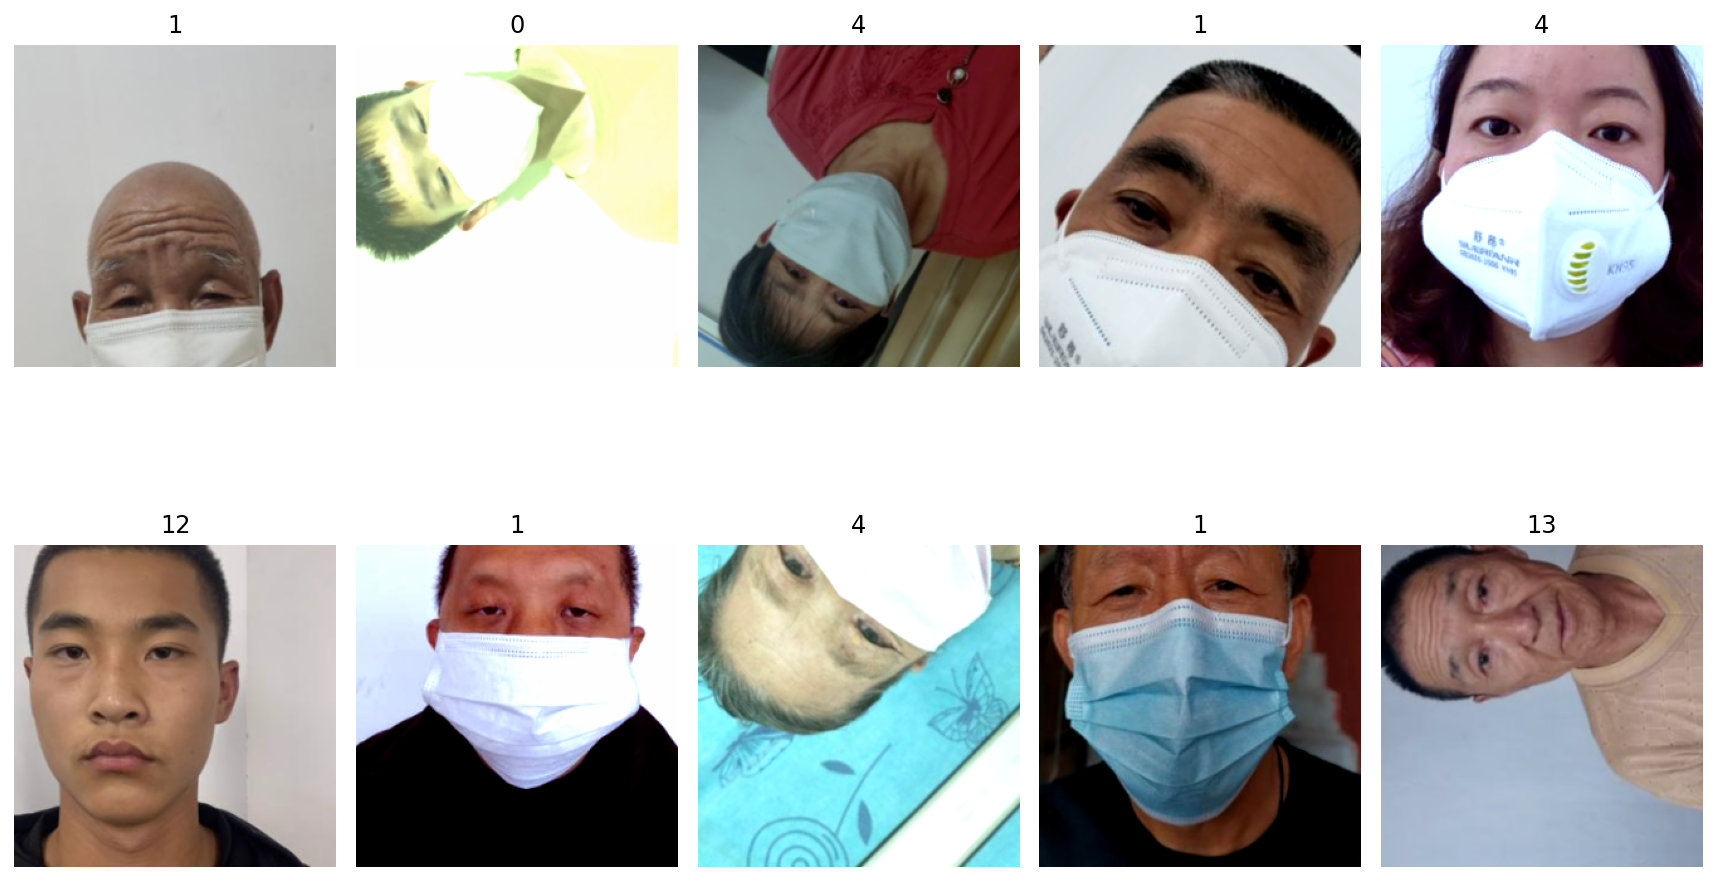

In [7]:
import matplotlib.pyplot as plt
import copy
%matplotlib inline

def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):
    dataset = copy.deepcopy(dataset)
    #we remove the normalize and tensor conversion from our augmentation pipeline
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab.item()])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)

In [8]:
train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=True
)


test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False
)

In [9]:
# batch of image tensor
next(iter(train_loader))[0].shape

torch.Size([64, 3, 256, 256])

In [10]:
# batch of the corresponding labels
next(iter(train_loader))[1].shape

torch.Size([64])

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
imagenet_resnet18 = torchvision.models.resnet18(pretrained=True)
print("네트워크 필요 입력 채널 개수", imagenet_resnet18.conv1.weight.shape[1])
print("네트워크 출력 채널 개수 (예측 class type 개수)", imagenet_resnet18.fc.weight.shape[0])
print(imagenet_resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /opt/ml/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html